In this lecture we continue with our deep learning journey and we will focus on some of the practical issues when training a generic feed-forward neural network. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline

### I. Sample, Batch and Epoch

In deep learning, there are few important concepts to distinguish. The three most important concepts are sample, batch, and epoch. 


##### Definition:
A **sample** in neural network is a single row of data. It contains inputs that are fed into the algorithm and an output that is used to compare to the prediction and calculate an error.

A training dataset is comprised of many rows of data, e.g. many samples. A sample may also be called an instance, an observation, an input vector, or a feature vector.

##### Definition:
In deep learning, the **batch size** is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient. A training dataset can be divided into one or more batches.

##### Definition:
When all training samples are used to create one batch, the learning algorithm is called **batch gradient descent**. When the batch is the size of one sample, the learning algorithm is called **stochastic gradient descent**, or **online gradient descent**. When the batch size is more than one sample and less than the size of the training dataset, the learning algorithm is called **mini-batch gradient descent**. In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples.

##### Definition:
In deep learning, one **epoch** means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified "batch size" number of samples. 

The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. Because we can easily implement the early stopping rule, and control the dropout layer, epochs in practicality tends to be a big number, as long as computation capacity is taken into consideration. It is common to create line plots that show epochs along the x-axis as time and the error or skill of the model on the y-axis. These plots are sometimes called learning curves. This is where the early stopping rule can kick in. These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset.

So to summarize, the batch size is a number of samples processed before the model is updated. The number of epochs is the number of complete passes through the training dataset. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset. The number of epochs can be set to an integer value between one and infinity.

The next question is how should choose the batch size. Given that very large datasets are often used to train deep learning neural networks, the batch size is rarely set to the size of the training dataset (usually less than 32). Smaller batch sizes are used for two main reasons:
  1. Smaller batch sizes are noisy, offering a regularizing effect and lower generalization error.
  2. Smaller batch sizes make it easier to fit one batch worth of training data in memory (i.e. when using a GPU).
  
We will now use a small multi-class classification problem as the basis to demonstrate the effect of batch size on learning. The scikit-learn class provides the make_blobs() function that can be used to create a multi-class classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class. We will configure the problem to have two input variables (to represent the x and y coordinates of the points) and a standard deviation of 2.0 for points within each group.

In [6]:
path='C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\\Introduction to Data Science Using Python\\datasets'
#path='C:\\Users\\GAO\\GAO_Jupyter_Notebook\\Datasets'
os.chdir(path)# prepare train and test dataset

In [7]:
# prepare train and test dataset
def prepare_data():
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
    
    for class_value in range(3):
        row_ix = np.where(y == class_value) # selecting indices of points with the class label
        plt.scatter(X[row_ix, 0], X[row_ix, 1]) # scatterplot for points with a different color
    plt.show()

    y = to_categorical(y) # one-hot encode output variable
    n_train = 500
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

def fit_model(trainX, trainy, testX, testy, n_batch): # fitting a model and plot learning curve
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax')) # 3 classes, therfore 3 neurons at the last layer
    
    opt = SGD(lr=0.01, momentum=0.9) # compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, batch_size=n_batch)
    
    plt.plot(history.history['accuracy'], label='train') 
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('batch='+str(n_batch), pad=-40) # plotting the learning curve

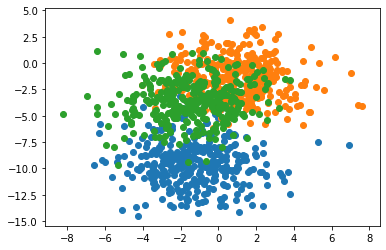

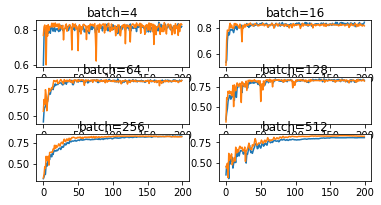

In [8]:
trainX, trainy, testX, testy = prepare_data()
# create learning curves for different batch sizes
batch_sizes = [4, 16, 64, 128, 256, 512]
for i in range(len(batch_sizes)):
    plot_no = 420 + (i+1) # determining the plot number
    plt.subplot(plot_no)
    fit_model(trainX, trainy, testX, testy, batch_sizes[i])
plt.show() # fiting model and plot learning curves for a batch size

The plots show that small batch results generally in rapid learning but a volatile learning process with higher variance in the classification accuracy. Larger batch sizes slow down the learning process but the final stages result in a convergence to a more stable model exemplified by lower variance in classification accuracy.

### II. Dropout Issues

In deep learning, a single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds. Three important takeaways include:

   1. Large weights in a neural network are a sign of a more complex network that has overfit the training data.
   2. Probabilistically dropping out nodes in the network is a simple and effective regularization method.
   3. A large network with more training and the use of a weight constraint are suggested when using dropout.
   
The idea of dropout is that during training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different 'view' of the configured layer. This really prevents us from going to the direction where we train a large set of neural networks with different network topology, and then average them in some way to get a more robust prediction. 

Dropout is implemented per-layer in a neural network. It can be used with most types of layers, such as dense fully connected layers, convolutional layers, and recurrent layers such as the long short-term memory network layer. Dropout may be implemented on any or all hidden layers in the network as well as the visible or input layer. It is not used on the output layer. Because the outputs of a layer under dropout are randomly subsampled, it has the effect of reducing the capacity or thinning the network during training. As such, a wider network, e.g. more nodes, may be required when using dropout. The default interpretation of the dropout hyperparameter is the probability of training a given node in a layer, where 1.0 means no dropout, and 0.0 means no outputs from the layer. A good value for dropout in a hidden layer is between 0.5 and 0.8. Input layers use a larger dropout rate, such as of 0.8.

Dropout is not used after training when making a prediction with the fit network. The weights of the network will be larger than normal because of dropout. Therefore, before finalizing the network, the weights are first scaled by the chosen dropout rate. The network can then be used as per normal to make predictions. The rescaling of the weights can be performed at training time instead, after each weight update at the end of the mini-batch. This is sometimes called “inverse dropout” and does not require any modification of weights during training. Both the Keras and PyTorch deep learning libraries implement dropout in this way.

A good rule of thumb is to divide the number of nodes in the layer before dropout by the proposed dropout rate and use that as the number of nodes in the new network that uses dropout. For example, a network with 100 nodes and a proposed dropout rate of 0.5 will require 200 nodes (100 / 0.5) when using dropout.

Like other regularization methods, dropout is more effective on those problems where there is a limited amount of training data and the model is likely to overfit the training data. Problems where there is a large amount of training data may see less benefit from using dropout.

Also, keep in mind that network weights will increase in size in response to the probabilistic removal of layer activations. Large weight size can be a sign of an unstable network.

### III. Network Topology

This is a hard topic but there is a few rule-of-thumbs. We will mainly focus on feedforward artificial neural networks (ANNs).

For the input layer, the number of neurons comprising that layer is usually set to be equal to the number of features (columns) in the data. Some ANN configurations add one additional node for a bias term. You can increase the number a little bit but it usually doesn't gain much. 

For the output layer, If the ANN is a regressor, then the output layer has a single node. If the ANN is a classifier, then it also has a single node unless the softmax activation function is used in which case the output layer has one node per class label in your model.

The hard part is the hidden layers. If your data is linearly separable (which you often know by the time you begin coding a ANN) then you don't need any hidden layers at all. Of course, you don't need an ANN to resolve your data either, but it will still do the job. If the dataset is not super complex, one hidden layer is sufficient for the large majority of problems. If we need the hidden layer, then the optimal size of the hidden layer is usually between the size of the input and size of the output layers. In many cases, the choice of the activation function as well as the regularization and dropout performed on the ANN is even more important than the network topology itself. 

### IV. Learning Rate and Momentum

During the training stage in deep learning, the backpropagation of error estimates the amount of error for which the weights of a node in the network are responsible. Instead of updating the weight with the full amount, it is scaled by the learning rate. This means that a learning rate of 0.1, a traditionally common default value, would mean that weights in the network are updated 10% of the estimated weight error each time the weights are updated. Generally, a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights but may take significantly longer to train. When the learning rate is too large, gradient descent can inadvertently increase rather than decrease the training error. As a rule-of-thumb, smaller batch sizes are better suited to smaller learning rates given the noisy estimate of the error gradient.

Training a neural network can be made easier with the addition of history to the weight update. Specifically, an exponentially weighted average of the prior updates to the weight can be included when the weights are updated. This change to stochastic gradient descent is called **momentum** and adds inertia to the update procedure, causing many past updates in one direction to continue in that direction in the future. Momentum can accelerate learning on those problems where the high-dimensional “weight space” that is being navigated by the optimization process has structures that mislead the gradient descent algorithm, such as flat regions or steep curvature. In essence, the momentum algorithm introduces a velocity-type variable that introduces the direction and speed at which the parameters move through parameter space. The velocity is set to an exponentially decaying average of the negative gradient. It has the effect of smoothing the optimization process, slowing updates to continue in the previous direction instead of getting stuck or oscillating. Momentum is set to a value greater than 0.0 and less than one, where common values such as 0.9 and 0.99 are used in practice. Momentum does not make it easier to configure the learning rate, as the step size is independent of the momentum. Instead, momentum can improve the speed of the optimization process in concert with the step size, improving the likelihood that a better set of weights is discovered in fewer training epochs.

An alternative to using a fixed learning rate is to instead vary the learning rate over the training process. The way in which the learning rate changes over time (training epochs) is referred to as the **learning rate schedule** or **learning rate decay**. The simplest learning rate schedule is to decrease the learning rate linearly from a large initial value to a small value. This allows large weight changes in the beginning of the learning process and small changes or fine-tuning towards the end of the learning process. The idea is that we can learn a bit faster at the beginning but then slow down as the problem gets more 'sophisticated'. In practice, it is common to decay the learning rate linearly until specific iteration $\tau$. After this particular iteration $\tau$, it is common to leave the learning rate constant.

There is another way to make the learning more adaptive to the data. This is called **adaptive learning rate**. Although no single method works best on all problems, there are three adaptive learning rate methods that have proven to be robust over many types of neural network architectures and problem types. They are **AdaGrad**, **RMSProp**, and **Adam**, and all maintain and adapt learning rates for each of the weights in the model.

Among all these optimization algorithms, Adam is the one worth mentioning. Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. It lierally stands for adaptive moment estimation. When introducing the algorithm, the authors list the attractive benefits of using Adam on non-convex optimization problems, as follows:

   - Straightforward to implement.
   - Computationally efficient.
   - Little memory requirements.
   - Invariant to diagonal rescale of the gradients.
   - Well suited for problems that are large in terms of data and/or parameters.
   - Appropriate for non-stationary objectives.
   - Appropriate for problems with very noisy/or sparse gradients.
   - Hyper-parameters have intuitive interpretation and typically require little tuning.
   
Adam is different to classical stochastic gradient descent. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training. The authors describe Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:
   - Adaptive Gradient Algorithm (AdaGrad) that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
   - Root Mean Square Propagation (RMSProp) that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance). Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages. The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

Adam has several configuration parameters. Good default settings for the tested machine learning problems are alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8. In detail:
   1. alpha: also referred to as the learning rate or step size. The proportion that weights are updated (e.g. 0.001). Larger values (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values (e.g. 1.0E-5) slow learning right down during training
   2. beta1: the exponential decay rate for the first moment estimates (e.g. 0.9).
   3. beta2: the exponential decay rate for the second-moment estimates (e.g. 0.999). This value should be set close to 1.0 on problems with a sparse gradient (e.g. NLP and computer vision problems).
   4. epsilon: is a very small number to prevent any division by zero in the implementation (e.g. 10E-8).
   
The paper by Ruder (2016) is a very readable paper that summarizes the current status of the gradient descent algorithm. Additionally the original paper for Adam is also fairly readable. Both of these papers are stored in the respective websites: 
   - Adam's paper: https://arxiv.org/abs/1412.6980
   - Overview paper: https://arxiv.org/abs/1609.04747    

### V. Neural Network Playground

For educational purpose, the neural network playground driven by Google's TensorFlow platform can be used to visualize the impact of fine-tuning the network parameters and topologies. In this playground, you can change many things such as data types, network topology, learning rate, regularization, and batch size etc. The website has the interactive feature so data scientists can explore how changing these aforementioned things will impact the performance of network. The tool is here: https://playground.tensorflow.org/. It's extremely fun to play with it!

### VI. Understanding Learning Curve

We will now go over some basic diagnostics of learning curves in TensorFlow. First, let's look at what underfitting looks like:

In [3]:
mpath="https://machinelearningmastery.com/wp-content/uploads/2019/02/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Does-Not-Have-Sufficient-Capacity.png"
Image(url=mpath, width=350, height=350)

An underfit model may also be identified by a training loss that is decreasing and continues to decrease at the end of the plot. This indicates that the model is capable of further learning and possible further improvements and that the training process was halted prematurely. Below is an example:

In [4]:
mpath="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Requires-Further-Training.png"
Image(url=mpath, width=350, height=350)

Notice that the curves keep going down but they don't flatten out. This is a clear indication of underfitting. To fix this, we can increase epoch, play with the training vs. validation split, as well as adding more variables to the model.

A plot of learning curves shows overfitting if:
   - the plot of training loss continues to decrease with experience;
   - the plot of validation loss decreases to a point and begins increasing again.
   
Below is an example:

In [5]:
mpath="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-An-Overfit-Model.png"
Image(url=mpath, width=350, height=350)

A plot of learning curves shows a good fit if:
   - the plot of training loss decreases to a point of stability;
   - the plot of validation loss decreases to a point of stability and has a small gap with the training loss.
   
Continued training of a good fit will likely lead to an overfit.

Learning curves can also be used to diagnose properties of a dataset and whether it is relatively representative. An unrepresentative dataset means a dataset that may not capture the statistical characteristics relative to another dataset drawn from the same domain, such as between a train and a validation dataset. This can commonly occur if the number of samples in a dataset is too small, relative to another dataset. There are two common cases that could be observed: unrepresentative training data and unrepresentative validation data.

An unrepresentative training dataset means that the training dataset does not provide sufficient information to learn the problem, relative to the validation dataset used to evaluate it. This may occur if the training dataset has too few examples as compared to the validation dataset. This situation can be identified by a learning curve for training loss that shows improvement and similarly a learning curve for validation loss that shows improvement, but a large gap remains between both curves. Below, we see that the training curve is under the validation curve, suggesting that training data might be too small:

In [6]:
mpath="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png"
Image(url=mpath, width=350, height=350)

An unrepresentative validation dataset means that the validation dataset does not provide sufficient information to evaluate the ability of the model to generalize. This may occur if the validation dataset has too few examples as compared to the training dataset. This case can be identified by a learning curve for training loss that looks like a good fit (or other fits) and a learning curve for validation loss that shows noisy movements around the training loss. Below is an example:

In [7]:
mpath="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Validation-Dataset-the-May-be-too-Small-Relative-to-the-Training-Dataset.png"
Image(url=mpath, width=350, height=350)

It may also be identified by a validation loss that is lower than the training loss. In this case, it indicates that the validation dataset may be easier for the model to predict than the training dataset (see below):

In [8]:
mpath="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Validation-Dataset-that-is-Easier-to-Predict-than-the-Training-Dataset.png"
Image(url=mpath, width=350, height=350)

### VII. Choosing the Right Loss Functions

We now discuss the techniques of choosing the right loss functions. Each choice function is appropriate for different scenarios. 

Let's study regression problems first. While we know that the mean squared error (MSE) is the most common criteria for data scientists to evaluate models, there are other options. For instance, there may be regression problems in which the target value has a spread of values and when predicting a large value, we may not want to punish a model as heavily as mean squared error. Instead, we can first calculate the natural logarithm of each of the predicted values, then calculate the mean squared error. This is called the **Mean Squared Logarithmic Error loss**, or **MSLE** for short. It has the effect of relaxing the punishing effect of large differences in large predicted values.

As another example, on some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value. The **Mean Absolute Error**, or **MAE** loss is an appropriate loss function in this case as it is more robust to outliers. It is calculated as the average of the absolute difference between the actual and predicted values.

For binary classification problems, the cross entropy is the default loss function to use for binary classification problems. Mathematically, it is the preferred loss function under the inference framework of maximum likelihood under binary classification. It is the loss function to be evaluated first and only changed if we have a good reason.

An alternative to cross-entropy for binary classification problems is the **hinge loss function**, primarily developed for use with support vector machines (SVM) models. It is intended for use with binary classification where the target values are in the set that only contains -1, and 1. The hinge loss function encourages examples to have the correct sign, assigning more error when there is a difference in the sign between the actual and predicted class values. Reports of performance with the hinge loss are mixed, sometimes resulting in better performance than cross-entropy on binary classification problems.

For multiclass classification problems, cross-entropy can be specified as the loss function in Keras by specifying 'categorical_crossentropy' when compiling the model. The function requires that the output layer is configured with more than one nodes (one for each class), in this case three nodes, and a 'softmax' activation in order to predict the probability for each class. In turn, this means that the target variable must be one hot encoded. This is to ensure that each example has an expected probability of 1.0 for the actual class value and an expected probability of 0.0 for all other class values. 

### References:
   - https://keras.io/getting_started/intro_to_keras_for_researchers/
   - https://keras.io/getting_started/intro_to_keras_for_engineers/
   - https://keras.io/getting_started/learning_resources/
   - https://keras.rstudio.com/reference/fit.html
   - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
   - https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
   - https://datascience.stackexchange.com/questions/18414/are-there-any-rules-for-choosing-the-size-of-a-mini-batch
   - https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
   - https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
   - https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/
   - https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
   - https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
   - https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
   - https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
   - https://www.manning.com/books/deep-learning-with-python#toc
   - https://playground.tensorflow.org
   - Ruder, S. (2016). An overview of gradient descent optimization algorithms. 
   - Kingma, D. P. & Ba, J. (2014). Adam: A Method for Stochastic Optimization. 